# Capstone Project: Water Turbidity Prediction through Supervised Machine Learning Techniques

Most of water supply in New York City comes from the intake in Kensico reservoir. The water quality in the intake site is measured six times a day.

Water Turbidity is the measure of cloudiness of a fluid. A more turbid water would be more diffucult to treat to produce drinking water. Depending on how turbid the water affects the operational decisions of a water supply operator. My hypothesis is the turbidity is affected by the amount of precipitation received on the past 24 hours or so as well as the water level. However, there is no available data on the monitoring of Kensico reservoir level.


The Kensico reservoir serves more of a terminal than a storage. It receives water from six main reservoirs. These reservoirs have a water level and flow monitoring.

For the precipitation data, I gathered data from seven weather stations that are nearest to Kensico and the other six reservoirs.

<img src="nyreservoirs.png" style="width: 500px;"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
%matplotlib inline
import datetime
from datetime import timedelta

/Users/raei/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/raei/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/raei/anaconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


Datasets:
* New York Watershed Quality Data from [NYC Open Data](https://opendata.cityofnewyork.us/)
* New York Reservoir Data from [NYC Open Data](https://opendata.cityofnewyork.us/)
* New York Weather Data from [NOAA](https://www.noaa.gov/)

# Kensico Reservoir
## Turbidity
Turbidity is the Target Variable

In [2]:
ntu = pd.read_csv('waterquality.csv', usecols=['Date', 'Average 24hrTurbidity(NTU)'])
ntu['Date'] = pd.to_datetime(ntu['Date'], format = '%m/%d/%Y')
ntu = ntu.rename({'Date': 'DATE'}, axis=1)
ntu = ntu.rename({'Average 24hrTurbidity(NTU)': 'NTU'}, axis=1)
ntu = ntu.sort_values(by='DATE', ascending=True)
ntu.set_index('DATE', inplace=True)
ntu.shape

(1670, 1)

In [3]:
ntu.iloc[[0, -1]]

,NTU
DATE,
2015-05-10,0.98
2019-06-04,0.78


In [4]:
len(pd.date_range('2015-05-10', '2019-06-04'))

1487

There should be 1 data point for each day or 1487 data points. Given that there are 1670 data points in the dataframe, the duplicates must be removed.

In [5]:
ntu = ntu.loc[~ntu.index.duplicated(keep='first')]

In [6]:
len(ntu)

1485

Let's confirm if there are missing dates in the dataframe.

In [7]:
pd.date_range(start = '2015-05-10', end = '2019-06-04').difference(ntu.index)

DatetimeIndex(['2015-07-29', '2018-02-01'], dtype='datetime64[ns]', freq=None)

Adding the missing dates to the dataframe and filling in the missing values through interpolation.

In [8]:
idx = pd.date_range('2015-05-10', '2019-06-04')
ntu = ntu.reindex(idx, fill_value=np.nan)
ntu = ntu.interpolate()
ntu.isna().sum()

NTU    0
dtype: int64

In [9]:
#Checking the interpolated values
print(ntu[(ntu.index >= '2015-07-27') & (ntu.index < '2015-08-01')])
print(ntu[(ntu.index > '2018-01-29') & (ntu.index <= '2018-02-03')])

              NTU
2015-07-27  0.540
2015-07-28  0.600
2015-07-29  0.605
2015-07-30  0.610
2015-07-31  0.630
              NTU
2018-01-30  0.900
2018-01-31  0.880
2018-02-01  0.855
2018-02-02  0.830
2018-02-03  0.860


There are 1487 data points of average turbidity in the raw water intake from the Kensico reservoir.

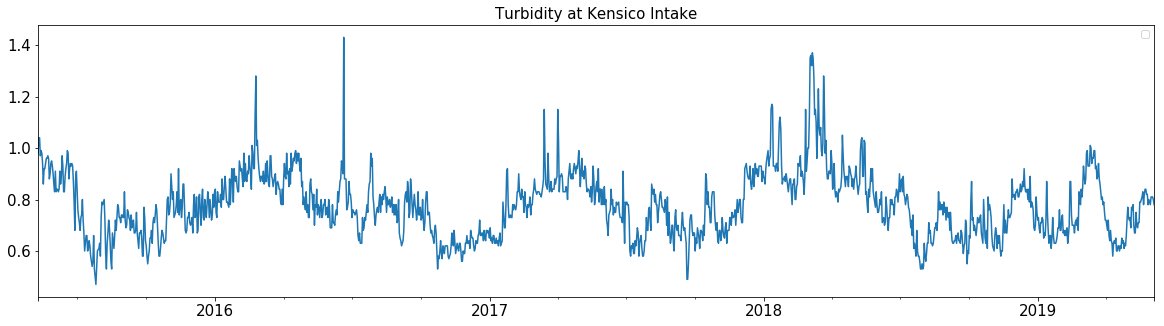

In [10]:
ntu.plot(figsize=(20,5), fontsize=15)
plt.title('Turbidity at Kensico Intake', fontsize=15)
plt.legend('')
plt.savefig('turbidity.png', dpi=500)

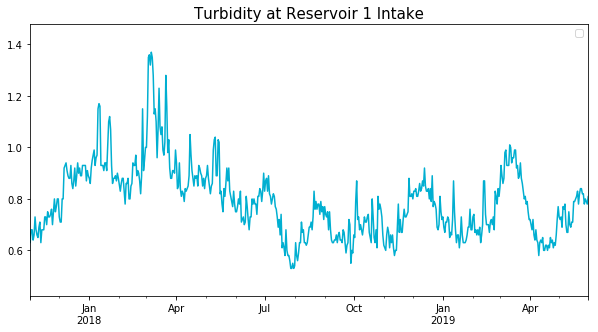

In [11]:
ntu.plot(figsize=(10,5), color='#01afd1')
plt.title('Turbidity at Reservoir 1 Intake', fontsize=15)
plt.xlim('2017-11-01','2019-05-31')
plt.legend('')
plt.savefig('turb.png', dpi=500, transparent=True)

## Precipitation

In [12]:
ken = pd.read_csv('del18weatherdata.csv', usecols=['DATE','NAME','PRCP'])
ken['NAME'].unique().tolist()

['WHITE PLAINS 3.1 NNW, NY US',
 'ARMONK 0.3 SE, NY US',
 'ARMONK 0.4 E, NY US',
 'ELMSFORD 0.8 SSW, NY US',
 'WESTCHESTER CO AIRPORT, NY US']

In [13]:
ken = ken[ken['NAME']=='WESTCHESTER CO AIRPORT, NY US']

I will create a function to apply the same manipulation technique applied to the turbidity dataset earlier. However, instead of interpolating the missing values, I will replace them with zero or no precipitation.

In [14]:
def prcp(df):
    if 'NAME' in df.columns:
        df = df.drop(columns='NAME')
    else:
        pass
    df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y-%m-%d')
    df = df.sort_values(by='DATE', ascending=True)
    df.set_index('DATE', inplace=True)
    df = df.loc[~df.index.duplicated(keep='first')] 
    df = df.replace(np.nan, 0)
    start_date = str(df.index[0].date())
    end_date = str(df.index[-1].date())
    idx = pd.date_range(start_date, end_date)
    df = df.reindex(idx, fill_value=0)
    return df

In [15]:
ken = prcp(ken)

**Merging the datasets**

In [16]:
# Assuming that the turbidity will be affected by the variables a day after
ntu.index = ntu.index + timedelta(days=1)
ntu.head()

,NTU
2015-05-11,0.98
2015-05-12,1.04
2015-05-13,1.04
2015-05-14,0.97
2015-05-15,0.99


In [17]:
data_k = ntu.join(ken)
len(data_k)

1487

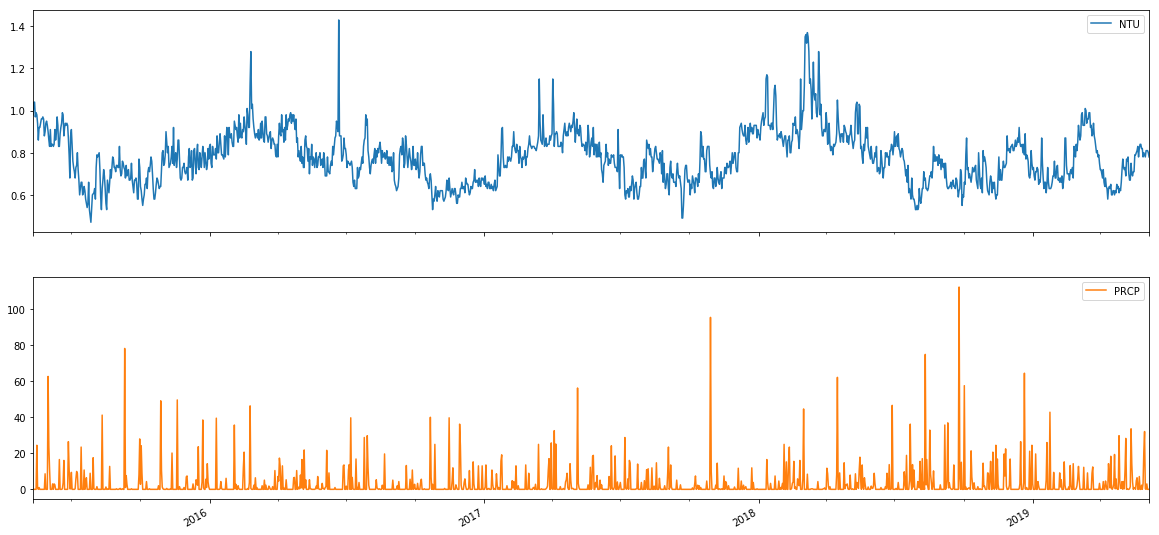

In [18]:
data_k.plot(subplots=True, figsize=(20, 10))
plt.legend(loc='best')

In [19]:
data_k.corr()

,NTU,PRCP
NTU,1.000000,-0.032435
PRCP,-0.032435,1.000000


Based on the plot and correlation, the precipitation in Kensico area is not enough to predict the turbidity.
Other factors such as elevation and flow should be put into consideration. However, since these information about the Kensico reservoir is not readiliy available,
I will consider the behavior of the six reservoirs wherein the Kensico reservoir gets its water.

# Considering the Six Reservoirs
Regarding the reservoir dataset, the limitation is that it starts from November 2017. If I decide to take the reservoir levels into considerations, I will be dropping 976 data points.
The six reservoirs are:
1. Ashokan / A
2. Schoharie / S
3. Rondout / REC
4. Neversink / NIC
5. Pepacton / ED
6. Cannonsville / WD

In [20]:
levels = pd.read_csv('reservoirlevels.csv')
levels = levels.rename({'Point_time': 'DATE'}, axis=1)
levels['DATE'] = pd.to_datetime(levels['DATE'], format = '%m/%d/%Y')

In [21]:
levels = levels.sort_values(by='DATE', ascending=True)
levels.set_index('DATE', inplace=True)

In [22]:
levels.iloc[[0, -1]]

,AUGEVolume,AUGEASTLEVANALOG,AUGWVOLUME,AUGWESTLEVANALOG,ASHREL,SICRESVOLUME,SICRESELEVANALOG,STPALBFLW,RECRESVOLUME,RECRESELEVANALOG,...,NICSTHFLW,NICCONFLW,EDIRESVOLUME,EDIRESELEVANALOG,EDRNTHFLW,EDRSTHFLW,EDRCONFLW,WDIRESVOLUME,WDIRESELEVANALOG,WDRFLW
DATE,,,,,,,,,,,,,,,,,,,,,
2017-11-01,65.36,577.86,36.34,577.89,18,12.92,1109.86,0.0,47.26,835.85,...,0.0,0.0,116.60,1264.45,51.7,0.0,0.0,47.69,1112.87,97.3
2019-05-31,77.12,586.23,44.94,590.01,21,18.34,1130.16,120.2,48.89,839.11,...,60.8,0.0,141.33,1279.19,47.6,49.2,0.0,94.70,1150.20,322.6


In [23]:
print(len(pd.date_range('2017-11-01', '2019-05-31')))
print(len(levels))

577
577


In [24]:
levels.isna().sum()

AUGEVolume          0
AUGEASTLEVANALOG    0
AUGWVOLUME          0
AUGWESTLEVANALOG    0
ASHREL              0
SICRESVOLUME        0
SICRESELEVANALOG    0
STPALBFLW           0
RECRESVOLUME        0
RECRESELEVANALOG    0
RECREL              0
NICRESVOLUME        0
NICRESELEVANALOG    0
NICNTHFLW           0
NICSTHFLW           0
NICCONFLW           0
EDIRESVOLUME        0
EDIRESELEVANALOG    0
EDRNTHFLW           0
EDRSTHFLW           0
EDRCONFLW           0
WDIRESVOLUME        0
WDIRESELEVANALOG    0
WDRFLW              0
dtype: int64

In [25]:
weather = pd.read_csv('reservoir_weather.csv', usecols = ['NAME','DATE', 'PRCP'])
REC = pd.read_csv('RECweather.csv',usecols = ['DATE', 'PRCP'])

In [26]:
weather['NAME'].unique().tolist()

['WEST HURLEY 0.1 S, NY US',
 'WALTON 6.5 W, NY US',
 'KERHONKSON 3.7 N, NY US',
 'LONG EDDY 6.5 NNE, NY US',
 'CALLICOON CENTER, NY US',
 'LANSING MANOR, NY US']

1. Ashokan / A - West Hurley
2. Schoharie / S - Lansing
3. Rondout / REC
4. Neversink / NIC - Callicoon
5. Pepacton / ED - Long Eddy
6. Cannonsville / WD - Walton

In [27]:
A = weather[weather['NAME']=='WEST HURLEY 0.1 S, NY US']
A = A.rename({'PRCP': 'PRCP_A'}, axis=1)
A = prcp(A)
S = weather[weather['NAME']=='LANSING MANOR, NY US']
S = S.rename({'PRCP': 'PRCP_S'}, axis=1)
S = prcp(S)
REC = REC.rename({'PRCP': 'PRCP_REC'}, axis=1)
REC = prcp(REC)
NIC = weather[weather['NAME']=='CALLICOON CENTER, NY US']
NIC = NIC.rename({'PRCP': 'PRCP_NIC'}, axis=1)
NIC = prcp(NIC)
ED = weather[weather['NAME']=='LONG EDDY 6.5 NNE, NY US']
ED = ED.rename({'PRCP': 'PRCP_ED'}, axis=1)
ED = prcp(ED)
WD = weather[weather['NAME']=='WALTON 6.5 W, NY US']
WD = WD.rename({'PRCP': 'PRCP_WD'}, axis=1)
WD = prcp(WD)

In [28]:
from functools import reduce
dfs = [ken, A, S, REC, NIC, ED, WD]
wea = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True, how='inner'), dfs)

In [29]:
print(wea.shape)
wea.iloc[[0,-1]]

(577, 7)


,PRCP,PRCP_A,PRCP_S,PRCP_REC,PRCP_NIC,PRCP_ED,PRCP_WD
2017-11-01,0.0,0.00,0.0,0.0,0.00,0.0,0.00
2019-05-31,0.3,0.02,0.0,5.3,0.15,0.1,0.37


In [30]:
len(wea['PRCP'][(wea['PRCP'] >= 0.1)])/len(wea)

0.41594454072790293

In [31]:
wea.isna().sum()

PRCP        0
PRCP_A      0
PRCP_S      0
PRCP_REC    0
PRCP_NIC    0
PRCP_ED     0
PRCP_WD     0
dtype: int64

In [32]:
data_l = levels.join(wea)

In [33]:
data_l.iloc[[0, -1]]

,AUGEVolume,AUGEASTLEVANALOG,AUGWVOLUME,AUGWESTLEVANALOG,ASHREL,SICRESVOLUME,SICRESELEVANALOG,STPALBFLW,RECRESVOLUME,RECRESELEVANALOG,...,WDIRESVOLUME,WDIRESELEVANALOG,WDRFLW,PRCP,PRCP_A,PRCP_S,PRCP_REC,PRCP_NIC,PRCP_ED,PRCP_WD
DATE,,,,,,,,,,,,,,,,,,,,,
2017-11-01,65.36,577.86,36.34,577.89,18,12.92,1109.86,0.0,47.26,835.85,...,47.69,1112.87,97.3,0.0,0.00,0.0,0.0,0.00,0.0,0.00
2019-05-31,77.12,586.23,44.94,590.01,21,18.34,1130.16,120.2,48.89,839.11,...,94.70,1150.20,322.6,0.3,0.02,0.0,5.3,0.15,0.1,0.37


In [34]:
data_l.isna().sum()

AUGEVolume          0
AUGEASTLEVANALOG    0
AUGWVOLUME          0
AUGWESTLEVANALOG    0
ASHREL              0
SICRESVOLUME        0
SICRESELEVANALOG    0
STPALBFLW           0
RECRESVOLUME        0
RECRESELEVANALOG    0
RECREL              0
NICRESVOLUME        0
NICRESELEVANALOG    0
NICNTHFLW           0
NICSTHFLW           0
NICCONFLW           0
EDIRESVOLUME        0
EDIRESELEVANALOG    0
EDRNTHFLW           0
EDRSTHFLW           0
EDRCONFLW           0
WDIRESVOLUME        0
WDIRESELEVANALOG    0
WDRFLW              0
PRCP                0
PRCP_A              0
PRCP_S              0
PRCP_REC            0
PRCP_NIC            0
PRCP_ED             0
PRCP_WD             0
dtype: int64

In [35]:
data = pd.merge(ntu, data_l, left_index=True, right_index=True)

In [36]:
print(data.shape)
data.head()

(577, 32)


,NTU,AUGEVolume,AUGEASTLEVANALOG,AUGWVOLUME,AUGWESTLEVANALOG,ASHREL,SICRESVOLUME,SICRESELEVANALOG,STPALBFLW,RECRESVOLUME,...,WDIRESVOLUME,WDIRESELEVANALOG,WDRFLW,PRCP,PRCP_A,PRCP_S,PRCP_REC,PRCP_NIC,PRCP_ED,PRCP_WD
2017-11-01,0.64,65.36,577.86,36.34,577.89,18,12.92,1109.86,0.0,47.26,...,47.69,1112.87,97.3,0.0,0.00,0.00,0.0,0.00,0.00,0.00
2017-11-02,0.63,64.95,577.58,36.82,578.59,11,13.28,1111.05,0.0,47.32,...,48.20,1113.33,97.6,0.0,0.04,0.02,0.0,0.08,0.06,0.05
2017-11-03,0.68,64.36,577.31,37.18,579.14,12,13.56,1111.97,0.0,47.22,...,48.66,1113.74,97.8,0.0,0.00,0.00,0.5,0.00,0.02,0.06
2017-11-04,0.68,63.71,576.94,37.49,579.56,12,13.78,1112.73,0.0,47.28,...,49.05,1114.09,98.0,0.0,0.00,0.04,0.0,0.04,0.06,0.09
2017-11-05,0.64,63.15,576.52,37.78,579.92,12,13.98,1113.39,0.0,47.36,...,49.35,1114.36,97.7,2.3,0.01,0.00,0.0,0.00,0.00,0.04


In [37]:
data.describe()

,NTU,AUGEVolume,AUGEASTLEVANALOG,AUGWVOLUME,AUGWESTLEVANALOG,ASHREL,SICRESVOLUME,SICRESELEVANALOG,STPALBFLW,RECRESVOLUME,...,WDIRESVOLUME,WDIRESELEVANALOG,WDRFLW,PRCP,PRCP_A,PRCP_S,PRCP_REC,PRCP_NIC,PRCP_ED,PRCP_WD
count,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,...,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000
mean,0.791274,71.313310,582.080139,40.797920,584.691820,234.757366,17.096690,1125.488163,72.702426,47.885910,...,83.942565,1141.852097,605.665858,3.694454,0.133865,0.115009,3.757712,0.165147,0.141438,0.122270
std,0.138993,7.269044,4.869657,4.024752,4.247849,257.388177,1.528601,11.235792,102.876970,0.664561,...,14.861174,11.588252,371.555927,9.680882,0.315445,0.265659,7.652919,0.330618,0.312063,0.296177
min,0.530000,52.630000,568.860000,31.370000,572.780000,8.000000,11.540000,1105.270000,0.000000,46.000000,...,47.690000,1112.870000,36.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.680000,67.000000,579.630000,38.020000,581.990000,13.000000,16.770000,1124.920000,0.000000,47.410000,...,83.460000,1142.470000,233.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.780000,73.140000,583.350000,41.170000,584.870000,22.000000,17.110000,1126.110000,12.400000,47.900000,...,89.650000,1146.460000,736.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.880000,77.430000,586.390000,44.370000,588.140000,546.000000,18.320000,1129.340000,122.100000,48.330000,...,93.110000,1149.120000,967.800000,2.500000,0.080000,0.090000,3.800000,0.140000,0.110000,0.050000
max,1.370000,81.070000,588.100000,47.690000,591.100000,623.000000,19.720000,1362.670000,569.600000,49.310000,...,99.110000,1151.950000,1009.600000,112.000000,2.430000,1.830000,53.800000,2.340000,2.400000,2.350000


In [38]:
data.corr()

,NTU,AUGEVolume,AUGEASTLEVANALOG,AUGWVOLUME,AUGWESTLEVANALOG,ASHREL,SICRESVOLUME,SICRESELEVANALOG,STPALBFLW,RECRESVOLUME,...,WDIRESVOLUME,WDIRESELEVANALOG,WDRFLW,PRCP,PRCP_A,PRCP_S,PRCP_REC,PRCP_NIC,PRCP_ED,PRCP_WD
NTU,1.000000,-0.022677,-0.102650,0.064915,-0.068837,-0.328319,-0.129264,-0.109538,0.123437,-0.016976,...,-0.116321,-0.153214,-0.283833,-0.094804,-0.163582,-0.122473,-0.054295,-0.129302,-0.068823,-0.089730
AUGEVolume,-0.022677,1.000000,0.989570,0.578931,0.654929,0.151306,0.675804,0.307349,-0.333519,0.654462,...,0.808400,0.796594,0.395613,0.073970,0.058724,0.072882,0.048499,0.077122,0.107804,0.102657
AUGEASTLEVANALOG,-0.102650,0.989570,1.000000,0.516695,0.624869,0.213996,0.675354,0.332636,-0.352260,0.624843,...,0.838948,0.836232,0.445750,0.076979,0.068200,0.073084,0.051187,0.082562,0.106318,0.100951
AUGWVOLUME,0.064915,0.578931,0.516695,1.000000,0.960953,-0.037641,0.673307,0.231328,-0.133666,0.450972,...,0.458054,0.421886,0.184029,0.060030,-0.006360,0.059566,0.063568,0.067616,0.088577,0.052991
AUGWESTLEVANALOG,-0.068837,0.654929,0.624869,0.960953,1.000000,0.080942,0.728634,0.310757,-0.195776,0.445504,...,0.588994,0.567184,0.310379,0.049426,-0.008842,0.034701,0.042980,0.053526,0.069300,0.022623
ASHREL,-0.328319,0.151306,0.213996,-0.037641,0.080942,1.000000,0.184908,0.122259,-0.344480,-0.064418,...,0.343333,0.365144,0.687320,0.112674,0.118783,0.086278,0.110447,0.103361,0.058865,0.104530
SICRESVOLUME,-0.129264,0.675804,0.675354,0.673307,0.728634,0.184908,1.000000,0.425605,-0.236297,0.602532,...,0.765322,0.756745,0.413864,0.119415,0.118532,0.159491,0.164075,0.174978,0.184806,0.140223
SICRESELEVANALOG,-0.109538,0.307349,0.332636,0.231328,0.310757,0.122259,0.425605,1.000000,-0.118077,0.221364,...,0.396482,0.405471,0.245673,0.080615,0.029854,0.043152,0.044854,0.052396,0.053962,0.040423
STPALBFLW,0.123437,-0.333519,-0.352260,-0.133666,-0.195776,-0.344480,-0.236297,-0.118077,1.000000,-0.171478,...,-0.459121,-0.448068,-0.502919,-0.044539,-0.089272,-0.098599,-0.086128,-0.086478,-0.071352,-0.043875
RECRESVOLUME,-0.016976,0.654462,0.624843,0.450972,0.445504,-0.064418,0.602532,0.221364,-0.171478,1.000000,...,0.551028,0.529066,0.158607,0.057850,0.097260,0.126993,0.110288,0.118312,0.167323,0.115978


Given that the Ashokan East Storage (AUGEVolume) and Ashokan East Elevation (AUGEASTLEVANALOG) are highly correlated, one variable can be dropped. Since the Elevation variable is more correlated to NTU than the Storage variable is, all storage values are dropped.

In [39]:
data.columns

Index(['NTU', 'AUGEVolume', 'AUGEASTLEVANALOG', 'AUGWVOLUME',
       'AUGWESTLEVANALOG', 'ASHREL', 'SICRESVOLUME', 'SICRESELEVANALOG',
       'STPALBFLW', 'RECRESVOLUME', 'RECRESELEVANALOG', 'RECREL',
       'NICRESVOLUME', 'NICRESELEVANALOG', 'NICNTHFLW', 'NICSTHFLW',
       'NICCONFLW', 'EDIRESVOLUME', 'EDIRESELEVANALOG', 'EDRNTHFLW',
       'EDRSTHFLW', 'EDRCONFLW', 'WDIRESVOLUME', 'WDIRESELEVANALOG', 'WDRFLW',
       'PRCP', 'PRCP_A', 'PRCP_S', 'PRCP_REC', 'PRCP_NIC', 'PRCP_ED',
       'PRCP_WD'],
      dtype='object')

In [40]:
data = data.drop(columns=['AUGEVolume', 'AUGWVOLUME', 'SICRESVOLUME','RECRESVOLUME',
       'NICRESVOLUME', 'EDIRESVOLUME', 'WDIRESVOLUME'])

In [41]:
data.head()

,NTU,AUGEASTLEVANALOG,AUGWESTLEVANALOG,ASHREL,SICRESELEVANALOG,STPALBFLW,RECRESELEVANALOG,RECREL,NICRESELEVANALOG,NICNTHFLW,...,EDRCONFLW,WDIRESELEVANALOG,WDRFLW,PRCP,PRCP_A,PRCP_S,PRCP_REC,PRCP_NIC,PRCP_ED,PRCP_WD
2017-11-01,0.64,577.86,577.89,18,1109.86,0.0,835.85,9.92,1430.03,38.9,...,0.0,1112.87,97.3,0.0,0.00,0.00,0.0,0.00,0.00,0.00
2017-11-02,0.63,577.58,578.59,11,1111.05,0.0,835.94,9.92,1429.90,39.0,...,0.0,1113.33,97.6,0.0,0.04,0.02,0.0,0.08,0.06,0.05
2017-11-03,0.68,577.31,579.14,12,1111.97,0.0,835.79,9.89,1429.99,39.0,...,0.0,1113.74,97.8,0.0,0.00,0.00,0.5,0.00,0.02,0.06
2017-11-04,0.68,576.94,579.56,12,1112.73,0.0,835.88,9.89,1430.22,39.1,...,0.0,1114.09,98.0,0.0,0.00,0.04,0.0,0.04,0.06,0.09
2017-11-05,0.64,576.52,579.92,12,1113.39,0.0,836.00,9.82,1430.47,39.1,...,0.0,1114.36,97.7,2.3,0.01,0.00,0.0,0.00,0.00,0.04


In [42]:
data.dtypes

NTU                 float64
AUGEASTLEVANALOG    float64
AUGWESTLEVANALOG    float64
ASHREL                int64
SICRESELEVANALOG    float64
STPALBFLW           float64
RECRESELEVANALOG    float64
RECREL              float64
NICRESELEVANALOG    float64
NICNTHFLW           float64
NICSTHFLW           float64
NICCONFLW           float64
EDIRESELEVANALOG    float64
EDRNTHFLW           float64
EDRSTHFLW           float64
EDRCONFLW           float64
WDIRESELEVANALOG    float64
WDRFLW              float64
PRCP                float64
PRCP_A              float64
PRCP_S              float64
PRCP_REC            float64
PRCP_NIC            float64
PRCP_ED             float64
PRCP_WD             float64
dtype: object

In [43]:
data = data.astype(float)

# Classification Modeling

Classify "turbid events" when turbidity is greather than 0.99 NTU.

In [44]:
df_class = pd.DataFrame(data['NTU'])

In [45]:
df_class['Event'] = False
df_class['Event'][(df_class['NTU'] > 0.99)] = True

/Users/raei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


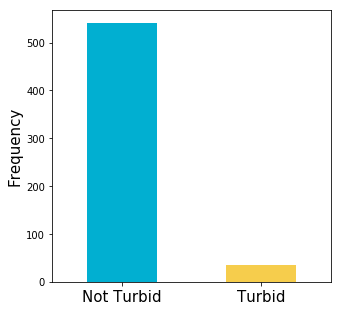

In [46]:
count_classes = pd.value_counts(df_class['Event'], sort = True).sort_index()
count_classes.plot(kind = 'bar', figsize=(5,5), color=['#01afd1','#f6cd4c'])
locs, _ = plt.xticks()
plt.xticks(locs, labels=['Not Turbid','Turbid'], fontsize = 15
#            , color='white'
          )
plt.xticks(rotation=0)
# plt.yticks(color='white')
plt.ylabel("Frequency", fontsize=15, 
#            color='white'
          )
# for spine in plt.gca().spines.values():
#     spine.set_edgecolor('white')
# plt.tick_params(color='white')
plt.savefig('class.png', dpi=500, transparent=True)

### Splitting Data and Scaling

In [47]:
from sklearn.model_selection import train_test_split
y = df_class['Event']
X = data.loc[:, data.columns != 'NTU']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [48]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [49]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Linear SVC

In [50]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()

In [51]:
from sklearn.model_selection import GridSearchCV
parameter_candidates = [
  {'C': [1, 10, 100, 1000], 'loss': ['hinge','squared_hinge'],
  'multi_class': ['ovr', 'crammer_singer'], 'max_iter': [100, 1000, 10000]}
]
grid_lsvc = GridSearchCV(estimator=lsvc, param_grid=parameter_candidates, n_jobs=-1)
grid_lsvc.fit(X_train, y_train)

/Users/raei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/raei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [1, 10, 100, 1000], 'loss': ['hinge', 'squared_hinge'], 'multi_class': ['ovr', 'crammer_singer'], 'max_iter': [100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [52]:
grid_lsvc.best_params_

{'C': 1, 'loss': 'hinge', 'max_iter': 100, 'multi_class': 'ovr'}

In [53]:
lscv = LinearSVC(C= 1, loss= 'hinge', max_iter= 100, multi_class= 'ovr')

In [54]:
from sklearn.metrics import accuracy_score
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)
print(accuracy_score(y_test, y_pred))

from sklearn.metrics import roc_curve, auc
y_score = lsvc.decision_function(X_test)
FPR, TPR, _ = roc_curve(y_test, y_score)
ROC_AUC = auc(FPR, TPR)
print(ROC_AUC)

0.9310344827586207
0.855832241153342


/Users/raei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


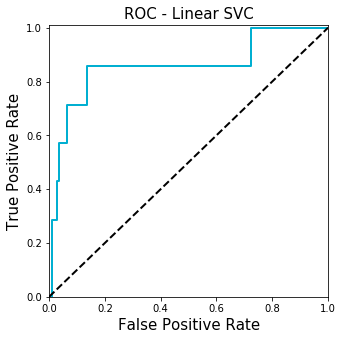

In [55]:

plt.figure(figsize=(5,5))
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 2, color='#01afd1')
plt.plot([0,1],[0,1], 'k--', linewidth = 2)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.01])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC - Linear SVC', fontsize= 15)
plt.savefig('roc.png', dpi=500, transparent=True)

### KNN Classifier

In [512]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
parameter_candidates = [
  {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [5, 15, 30, 60],
  'n_neighbors': [3,5, 10, 15, 20], 'weights': ['uniform', 'distance']}
]
grid_knn = GridSearchCV(estimator=knn, param_grid=parameter_candidates, n_jobs=-1)
grid_knn.fit(X_train, y_train)

/Users/raei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [5, 15, 30, 60], 'n_neighbors': [3, 5, 10, 15, 20], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [513]:
grid_knn.best_params_

{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}

In [514]:
knn = KNeighborsClassifier(algorithm= 'auto', leaf_size= 5, n_neighbors= 3, weights= 'uniform')

In [515]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [516]:
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))
FPR, TPR, _ = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

0.9396551724137931
0.6336828309305373


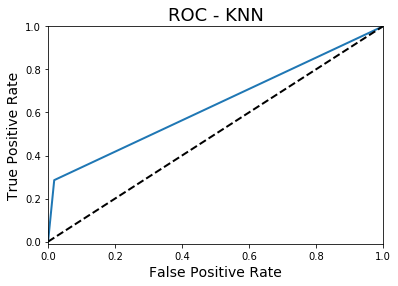

In [517]:
plt.figure()
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 2)
plt.plot([0,1],[0,1], 'k--', linewidth = 2)
plt.xlim([0.0,1.0])
plt.ylim([-0.01,1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC - KNN', fontsize= 18)
plt.show()

### Random Forest

In [518]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [519]:
parameter_candidates = [
  {'n_estimators': [10, 100, 1000, 10000], 'criterion': ['gini', 'entropy'],
  'bootstrap': [True, False]}
]
grid_rf = GridSearchCV(estimator=rf, param_grid=parameter_candidates, n_jobs=-1)
grid_rf.fit(X_train, y_train)

/Users/raei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [10, 100, 1000, 10000], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [520]:
grid_rf.best_params_

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 10}

In [521]:
rf = RandomForestClassifier(bootstrap= True, criterion= 'entropy', n_estimators= 10)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [522]:
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))
FPR, TPR, _ = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

0.9482758620689655
0.6382699868938401


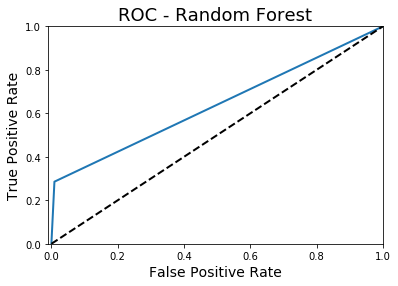

In [523]:
plt.figure()
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 2)
plt.plot([0,1],[0,1], 'k--', linewidth = 2)
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC - Random Forest', fontsize= 18)
plt.show()

----

Among the classification models, the best to use was the Linear SVC.

In [524]:
from sklearn.metrics import confusion_matrix
y_pred = lsvc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[108,   1],
       [  7,   0]])

In [525]:
column_names = list(X.columns.values)
feature_importances = pd.DataFrame(lsvc.coef_.reshape(-1,1),
                                    index = column_names,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
EDRSTHFLW,0.802875
AUGEASTLEVANALOG,0.645747
WDIRESELEVANALOG,0.608006
PRCP_REC,0.209387
PRCP_WD,0.208479
PRCP_ED,0.166462
STPALBFLW,0.125980
AUGWESTLEVANALOG,0.117078
NICNTHFLW,0.060350
PRCP,0.020334


* Ashokan / A - West Hurley
* Schoharie / S - Lansing
* Rondout / REC
* Neversink / NIC - Callicoon
* Pepacton / ED - Long Eddy
* Cannonsville / WD - Walton

The most important features are **Pepacton South Flow Release, Ashokan East Elevation and Cannonsville Elevation**. These reservoirs are the largest among them all.

## Regression Modelling

### Splitting Date and Scaling

In [89]:
from sklearn.model_selection import train_test_split
y = data['NTU']
X = data.loc[:, data.columns != 'NTU']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=1)

In [90]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Linear Regression

In [91]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [114]:
y_pred = lr.predict(X_test).reshape(-1,1)
y__test = y_test.values.reshape(-1,1)

In [115]:
y__test.shape

(116, 1)

In [116]:
y_pred.shape

(116, 1)

In [119]:
lr.score(y__test, y_pred)

ValueError: shapes (116,1) and (24,) not aligned: 1 (dim 1) != 24 (dim 0)

In [60]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 0.07515965507571531
Mean Squared Error: 0.011338189865467392
Root Mean Squared Error: 0.10648093662936757


### XGBoost Regression

In [61]:
from xgboost import XGBRegressor

In [62]:
parameter_candidates = [
  {'learning_rate': [0.05, 0.1, 0.2, 0.5], 'n_estimators': [10, 100, 150, 200, 250],
  'booster': ['gbtree', 'gblinear', 'dart']}
]
grid_xgb = GridSearchCV(estimator=XGBRegressor(), param_grid=parameter_candidates, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

/Users/raei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[18:37:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/raei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/raei/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'learning_rate': [0.05, 0.1, 0.2, 0.5], 'n_estimators': [10, 100, 150, 200, 250], 'booster': ['gbtree', 'gblinear', 'dart']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
grid_xgb.best_params_

{'booster': 'gbtree', 'learning_rate': 0.2, 'n_estimators': 250}

In [64]:
xgb = XGBRegressor(booster= 'gbtree', learning_rate= 0.2, n_estimators= 250)
xgb.fit(X_train, y_train)

[18:37:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [65]:
y_pred = xgb.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 0.0412194393009975
Mean Squared Error: 0.002843361651518596
Root Mean Squared Error: 0.05332318118340837


In [66]:
column_names = list(X.columns.values)
feature_importances = pd.DataFrame(xgb.feature_importances_.reshape(-1,1),
                                    index = column_names,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
RECREL,0.210647
NICNTHFLW,0.104776
EDRSTHFLW,0.104498
WDIRESELEVANALOG,0.088635
ASHREL,0.077748
EDRNTHFLW,0.051839
STPALBFLW,0.050943
NICRESELEVANALOG,0.050057
NICSTHFLW,0.048772
EDIRESELEVANALOG,0.038412


### Random Forest Regression

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [71]:
parameter_candidates = [
  {'bootstrap': [True, False], 'n_estimators': [10, 100, 150, 200, 250, 300]}
]
grid_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=parameter_candidates, n_jobs=-1)
grid_rfr.fit(X_train, y_train)

/Users/raei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'bootstrap': [True, False], 'n_estimators': [10, 100, 150, 200, 250, 300]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [72]:
grid_rfr.best_params_

{'bootstrap': True, 'n_estimators': 150}

In [73]:
rfr = XGBRegressor(bootstrap= True, n_estimators= 250)
rfr.fit(X_train, y_train)

[18:38:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/raei/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       gamma=0, importance_type='gain', learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=250, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [74]:
y_pred = rfr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 0.04239938306397405
Mean Squared Error: 0.002807159717026175
Root Mean Squared Error: 0.052982635995448314


----
Comparing the RMSE of the Regression models.

In [75]:
print('Root Mean Squared Error LR:', np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test)))) 
print('Root Mean Squared Error RFR:', np.sqrt(metrics.mean_squared_error(y_test, rfr.predict(X_test)))) 
print('Root Mean Squared Error XGB:', np.sqrt(metrics.mean_squared_error(y_test, xgb.predict(X_test))))

Root Mean Squared Error LR: 0.10648093662936757
Root Mean Squared Error RFR: 0.052982635995448314
Root Mean Squared Error XGB: 0.05332318118340837


The best regression model is **Random Forest Regressor**.

In [ ]:
EDRSTHFLW	0.802875
AUGEASTLEVANALOG	0.645747
WDIRESELEVANALOG	0.608006

In [76]:
column_names = list(X.columns.values)
feature_importances = pd.DataFrame(rfr.feature_importances_.reshape(-1,1),
                                    index = column_names,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
RECREL,0.203938
ASHREL,0.103440
EDRSTHFLW,0.083522
WDIRESELEVANALOG,0.079356
EDRNTHFLW,0.075536
NICNTHFLW,0.068732
STPALBFLW,0.051068
NICRESELEVANALOG,0.050031
EDIRESELEVANALOG,0.048521
RECRESELEVANALOG,0.039384


* Ashokan / A - West Hurley
* Schoharie / S - Lansing
* Rondout / REC
* Neversink / NIC - Callicoon
* Pepacton / ED - Long Eddy
* Cannonsville / WD - Walton

The most important features are **Rondout Flow/Release, Ashokan Flow/Release and Pepacton South Flow**.

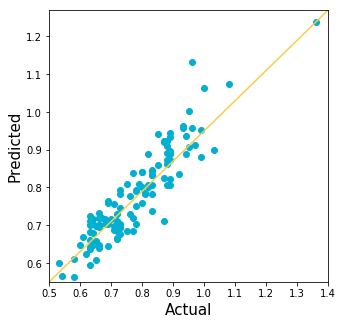

In [602]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, rfr.predict(X_test), color='#01afd1')
x = np.arange(0.5,1.5,.1)
y = .8*x+0.15
plt.xlim(0.5,1.4)
plt.ylim(0.55,1.27)
plt.xlabel('Actual', fontsize = 15)
plt.ylabel('Predicted', fontsize = 15)
plt.plot(x,y, c='#f6cd4c')
plt.savefig('rfr.png', dpi=500, transparent=True)

In [601]:
.8*.5+0.15

0.55